<a href="https://colab.research.google.com/github/GanesH2O/Downscale-GRACE/blob/main/03_1_Downscaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rioxarray
!pip install pymannkendall
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 72.3 MB/s eta 0:00:00


In [ ]:
import rioxarray
import geopandas as gpd
import joblib
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import theilslopes
import numpy as np

In [ ]:
nepal_shp = gpd.read_file('/content/drive/MyDrive/Paperwork/SHP/AOI.shp')
nepal_shp = nepal_shp.set_crs('epsg:4326')
world_shp = gpd.read_file('/content/drive/MyDrive/Paperwork/SHP/world-administrative-boundaries.shp')
world_shp = world_shp.set_crs('epsg:4326')

In [ ]:
model_rf = joblib.load(f'/content/drive/MyDrive/Paperwork/RFM/G3S_xgboost_model.pkl')
# Access and print the feature names (variables used for training)
if hasattr(model_rf, 'feature_names_in_'):
    print("Variables used for training:")
    print(model_rf.feature_names_in_)
else:
    print("Feature names not found in the model object.")

Variables used for training:
['lst_day' 'lst_night' 'NDVI' 'EVI' 'population_density' 'precipitation'
 'elevation' 'slope' 'aspect']


In [ ]:
df_ori = pd.read_csv(f'/content/drive/MyDrive/Paperwork/RFM/PREDICTION/RFM_PREDICTION.csv')
df_ori
df_ori = df_ori.dropna()
df_ori['time'] = pd.to_datetime(df_ori['time'])
order = ['lst_day','lst_night','NDVI','EVI','population_density','precipitation','elevation','slope','aspect'] # Corrected the list with correct column names
X = df_ori[order]
X

,lst_day,lst_night,NDVI,EVI,population_density,precipitation,elevation,slope,aspect
39,21.585450,4.254679,0.478900,0.294375,777.0,0.043,193,0.036687,161.565050
40,18.658167,5.215858,0.516600,0.345725,334.0,0.047,189,0.012761,45.000000
41,18.324408,5.541173,0.626450,0.438675,438.0,0.045,194,0.086635,43.191260
42,18.904736,7.375655,0.291850,0.157825,478.0,0.045,199,0.193906,54.196655
43,17.772950,6.460873,0.343325,0.168150,580.0,0.052,216,0.155676,64.495865
...,...,...,...,...,...,...,...,...,...
1555109,23.897705,12.242594,0.764850,0.442400,250.0,0.004,215,1.531683,355.922970
1555110,18.363229,9.665955,0.839800,0.537375,105.0,0.004,352,3.741511,356.933350
1555111,16.666749,7.106753,0.733750,0.392300,61.0,0.004,1032,5.317967,345.606050
1555112,10.329899,2.755615,0.807075,0.300675,14.0,0.005,3002,5.754451,342.612800


# Downscale

In [ ]:
y_predicted = model_rf.predict(X)

In [ ]:
df_X = df_ori[['time','x','y']]
df_X['GWS_DS'] = y_predicted
df_X

<ipython-input-8-2157667258>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X['GWS_DS'] = y_predicted


,time,x,y,GWS_DS
39,2003-01-01,77.049995,27.949999,76.222519
40,2003-01-01,77.049995,28.050000,461.094788
41,2003-01-01,77.049995,28.150000,157.347122
42,2003-01-01,77.049995,28.250000,56.115337
43,2003-01-01,77.049995,28.349998,174.473846
...,...,...,...,...
1555109,2020-12-01,88.850000,26.949999,-7.215387
1555110,2020-12-01,88.850000,27.050000,66.518341
1555111,2020-12-01,88.850000,27.150000,62.656738
1555112,2020-12-01,88.850000,27.250000,28.232471


In [ ]:
# Convert dataframe to xarray Dataset
ds = xr.Dataset.from_dataframe(df_X.set_index(['time', 'y', 'x']))

# Export to NetCDF
ds.to_netcdf(f'/content/drive/MyDrive/Paperwork/RFM/RESULTS/GWSA_0.1_Original.nc')
ds

<xarray.Dataset> Size: 6MB
Dimensions:  (time: 216, y: 58, x: 119)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2020-12-01
  * y        (y) float64 464B 24.05 24.15 24.25 24.35 ... 29.55 29.65 29.75
  * x        (x) float64 952B 77.05 77.15 77.25 77.35 ... 88.65 88.75 88.85
Data variables:
    GWS_DS   (time, y, x) float32 6MB nan nan nan nan nan ... nan nan nan nan

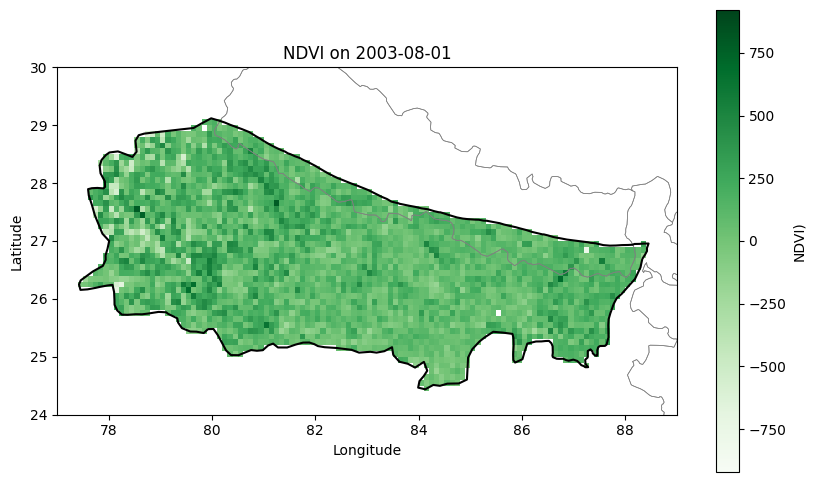

In [ ]:
ds = ds.rio.write_crs('epsg:4326')
ds = ds.rio.clip(nepal_shp.geometry, all_touched=False)
#ds = ds.rio.clip_box(minx=x_min, miny=y_min, maxx=x_max, maxy=y_max)
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 7
time_stamp = ds.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the ds NDVIitation data for the selected time
dsTR = ds.GWS_DS.isel(time=t).transpose('y', 'x')
dsTR.plot(ax=ax, cmap='Greens', add_colorbar=True, cbar_kwargs={'label': 'NDVI)'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'NDVI on {time_str}')

plt.show()

# Visualize

In [ ]:
GR = (xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/G3S_gwsa_full.nc')
      .sortby('y')
      .rio.write_crs('epsg:4326')
      .sel(time=slice('2003-01-01', '2020-12-31'))
      .rio.clip(nepal_shp.geometry, all_touched=True)
      .rename({'gwsa': 'GWS'})
      .drop_vars('spatial_ref'))
GR
# Interpolate along time dimension
GR = GR.interpolate_na(dim='time', method='linear')

# Verify
print(f"Missing values after interpolation: {GR['GWS'].isnull().sum().item()}")

Missing values after interpolation: 22680


In [ ]:
GR_DS = xr.open_dataset('/content/drive/MyDrive/Paperwork/RFM/RESULTS/GWSA_0.1_Original.nc')
#GR_DS = (xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/CHIRPS.nc')
        #.rename({'latitude': 'y', 'longitude': 'x'}))
GR_DS = GR_DS.rio.write_crs('epsg:4326')
GR_DS = GR_DS.sel(time=slice('2003-01-01','2020-12-31'))
GR_DS = GR_DS.drop_vars('spatial_ref')
GR_DS

<xarray.Dataset> Size: 6MB
Dimensions:  (time: 216, y: 58, x: 119)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2020-12-01
  * x        (x) float64 952B 77.05 77.15 77.25 77.35 ... 88.65 88.75 88.85
  * y        (y) float64 464B 24.05 24.15 24.25 24.35 ... 29.55 29.65 29.75
Data variables:
    GWS_DS   (time, y, x) float32 6MB ...

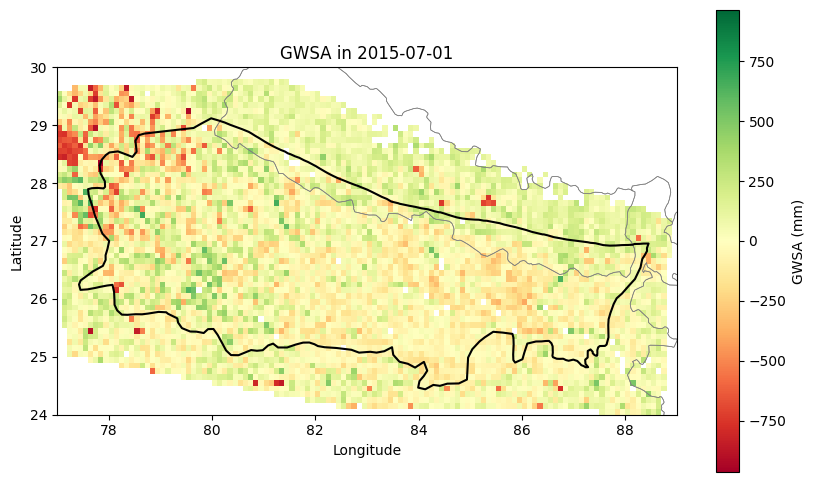

In [ ]:
# Assuming GR_DS and nepal_shp are already loaded and processed
GR_DS = GR_DS.rio.write_crs('epsg:4326')
#GR_DS = GR_DS.rio.clip(nepal_shp.geometry, all_touched=True)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 150
time_stamp = GR_DS.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the GR_DS gwsaitation data for the selected time
GR_DSTR = GR_DS.GWS_DS.isel(time=t).transpose('y', 'x')
GR_DSTR.plot(ax=ax, cmap='RdYlGn', add_colorbar=True, cbar_kwargs={'label': 'GWSA (mm)'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'GWSA in {time_str}')

plt.show()

<ipython-input-15-2033327416>:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df1 = df1.resample("M").mean()
<ipython-input-15-2033327416>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = df2.resample("M").mean()


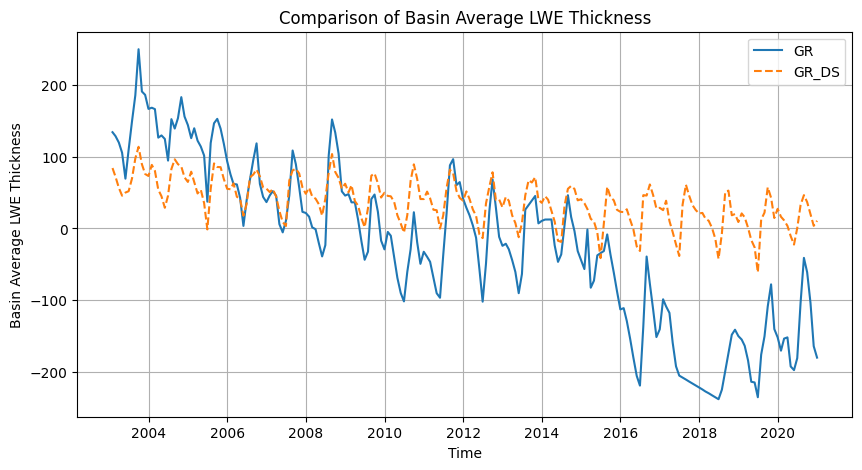

In [ ]:
# Extract the variables
var1 = GR["GWS"]
var2 = GR_DS["GWS_DS"]

# Compute the spatial mean (basin average)
basin_avg1 = var1.mean(dim=["x", "y"])  # Adjust dims if different
basin_avg2 = var2.mean(dim=["x", "y"])

# Convert to Pandas DataFrame for easy handling
df1 = basin_avg1.to_dataframe().dropna()
df2 = basin_avg2.to_dataframe().dropna()

# Convert to monthly averages to align them
df1 = df1.resample("M").mean()
df2 = df2.resample("M").mean()

# Merge the datasets on time index
df = df1.join(df2, how="inner")

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["GWS"], label="GR")
plt.plot(df.index, df["GWS_DS"], label="GR_DS", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Basin Average LWE Thickness")
plt.title("Comparison of Basin Average LWE Thickness")
plt.legend()
plt.grid()
plt.show()

# Residual Correction

In [ ]:
# Fill NaN values using linear interpolation along x and y
#GR_DS_filled = GR_DS.interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear')

# Define target grid
regrid_lat = np.arange(24.25, 29.75, 0.5)
regrid_lon = np.arange(77.25, 88.75, 0.5)

# Regrid with slinear
GR_DS_RE = GR_DS.interp(x=regrid_lon, y=regrid_lat, method='slinear')

# Check for remaining missing values
# Calculate the sum of nulls per variable
null_counts = GR_DS_RE.isnull().sum()

# Print missing values for each variable
print("Missing values in regridded data:")
for var_name in null_counts.data_vars:
    print(f"- {var_name}: {null_counts[var_name].item()}")


Missing values in regridded data:
- GWS_DS: 10673


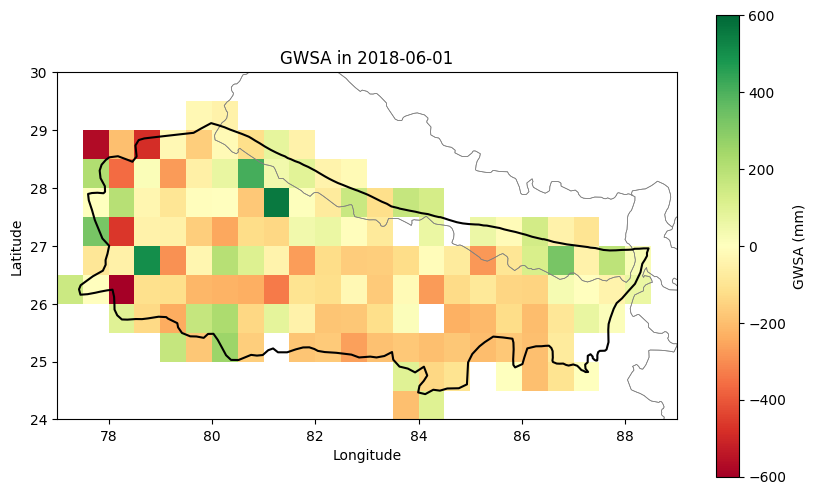

In [ ]:
# Assuming GR_DS_RE and nepal_shp are already loaded and processed
GR_DS_RE = GR_DS_RE.rio.write_crs('epsg:4326')
GR_DS_RE = GR_DS_RE.rio.clip(nepal_shp.geometry, all_touched=True)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 185
time_stamp = GR_DS_RE.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the GR_DS_RE gwsaitation data for the selected time
GR_DS_RETR = GR_DS_RE.GWS_DS.isel(time=t).transpose('y', 'x')
GR_DS_RETR.plot(ax=ax, cmap='RdYlGn', add_colorbar=True, cbar_kwargs={'label': 'GWSA (mm)'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'GWSA in {time_str}')

plt.show()

In [ ]:
predicted = GR_DS_RE['GWS_DS']
actual = GR['GWS']
df_pred = predicted.to_dataframe()
df_actual = actual.to_dataframe()

In [ ]:
df_pred

spatial_ref  GWS_DS
time       y     x                         
2003-01-01 24.25 77.25            0     NaN
                 77.75            0     NaN
                 78.25            0     NaN
                 78.75            0     NaN
                 79.25            0     NaN
...                             ...     ...
2020-12-01 29.25 86.25            0     NaN
                 86.75            0     NaN
                 87.25            0     NaN
                 87.75            0     NaN
                 88.25            0     NaN

[54648 rows x 2 columns]

In [ ]:
df_actual

GWS
time       y     x         
2003-01-01 24.25 77.25  NaN
                 77.75  NaN
                 78.25  NaN
                 78.75  NaN
                 79.25  NaN
...                     ...
2020-12-01 29.25 86.25  NaN
                 86.75  NaN
                 87.25  NaN
                 87.75  NaN
                 88.25  NaN

[54648 rows x 1 columns]

In [ ]:
df_combined = pd.concat([df_pred, df_actual], axis=1)
df_combined

spatial_ref  GWS_DS  GWS
time       y     x                              
2003-01-01 24.25 77.25            0     NaN  NaN
                 77.75            0     NaN  NaN
                 78.25            0     NaN  NaN
                 78.75            0     NaN  NaN
                 79.25            0     NaN  NaN
...                             ...     ...  ...
2020-12-01 29.25 86.25            0     NaN  NaN
                 86.75            0     NaN  NaN
                 87.25            0     NaN  NaN
                 87.75            0     NaN  NaN
                 88.25            0     NaN  NaN

[54648 rows x 3 columns]

In [ ]:
df_combined["difference"] = df_combined["GWS_DS"] - df_combined["GWS"]
df_combined

spatial_ref  GWS_DS  GWS  difference
time       y     x                                          
2003-01-01 24.25 77.25            0     NaN  NaN         NaN
                 77.75            0     NaN  NaN         NaN
                 78.25            0     NaN  NaN         NaN
                 78.75            0     NaN  NaN         NaN
                 79.25            0     NaN  NaN         NaN
...                             ...     ...  ...         ...
2020-12-01 29.25 86.25            0     NaN  NaN         NaN
                 86.75            0     NaN  NaN         NaN
                 87.25            0     NaN  NaN         NaN
                 87.75            0     NaN  NaN         NaN
                 88.25            0     NaN  NaN         NaN

[54648 rows x 4 columns]

In [ ]:
df_selected = df_combined.iloc[:, [2]]
df_selected

GWS
time       y     x         
2003-01-01 24.25 77.25  NaN
                 77.75  NaN
                 78.25  NaN
                 78.75  NaN
                 79.25  NaN
...                     ...
2020-12-01 29.25 86.25  NaN
                 86.75  NaN
                 87.25  NaN
                 87.75  NaN
                 88.25  NaN

[54648 rows x 1 columns]

In [ ]:
# 1. Select the relevant columns
residual_df = df_combined[['difference']]

# 2. Convert to xarray Dataset
residual = xr.Dataset.from_dataframe(residual_df)

# 3. Display the Dataset (optional)
residual

<xarray.Dataset> Size: 439kB
Dimensions:     (time: 216, y: 11, x: 23)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2020-12-01
  * y           (y) float64 88B 24.25 24.75 25.25 25.75 ... 28.25 28.75 29.25
  * x           (x) float64 184B 77.25 77.75 78.25 78.75 ... 87.25 87.75 88.25
Data variables:
    difference  (time, y, x) float64 437kB nan nan nan nan ... nan nan nan nan

In [ ]:
regrid_lat = np.arange(24.05, 29.80, 0.1)
regrid_lon = np.arange(77.05, 88.90, 0.1)
#residual at 0.1 degree
residual1 = residual.interp(x=regrid_lon,y = regrid_lat,method='slinear')
residual1 = residual1.rio.write_crs('epsg:4326')
#residual1 = residual1.rio.clip_box(minx=x_min, miny=y_min, maxx=x_max, maxy=y_max)
residual1

<xarray.Dataset> Size: 12MB
Dimensions:      (time: 216, y: 58, x: 119)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2020-12-01
  * x            (x) float64 952B 77.05 77.15 77.25 77.35 ... 88.65 88.75 88.85
  * y            (y) float64 464B 24.05 24.15 24.25 24.35 ... 29.55 29.65 29.75
    spatial_ref  int64 8B 0
Data variables:
    difference   (time, y, x) float64 12MB nan nan nan nan ... nan nan nan nan

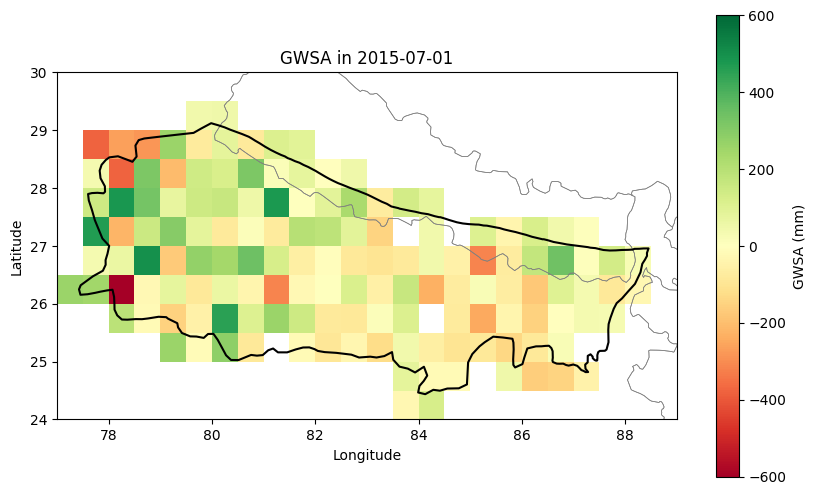

In [ ]:
x_min = 77.025
y_min = 24.025
x_max = 88.975
y_max = 29.975# Assuming residual and nepal_shp are already loaded and processed
residual = residual.rio.write_crs('epsg:4326')
residual = residual.rio.clip(nepal_shp.geometry, all_touched=True)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 150
time_stamp = residual.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the residual gwsaitation data for the selected time
residualTR = residual.difference.isel(time=t).transpose('y', 'x')
residualTR.plot(ax=ax, cmap='RdYlGn', add_colorbar=True, cbar_kwargs={'label': 'GWSA (mm)'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'GWSA in {time_str}')

plt.show()

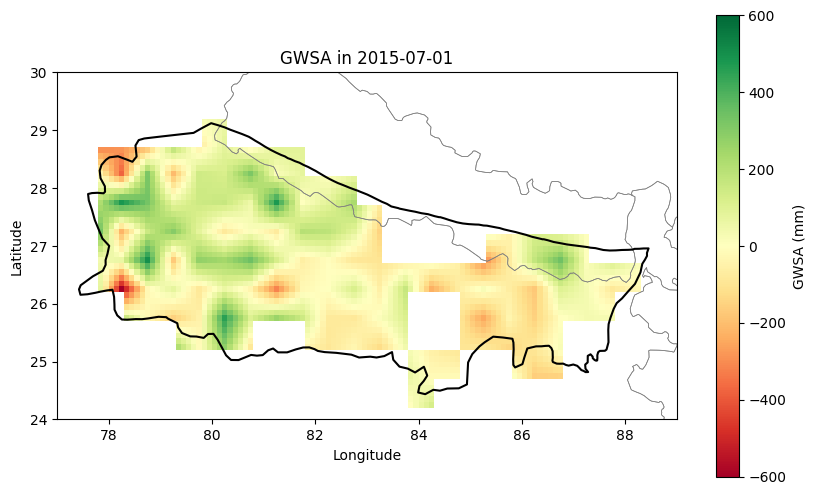

In [ ]:
# Assuming residual1 and nepal_shp are already loaded and processed
residual1 = residual1.rio.write_crs('epsg:4326')
#residual1 = residual1.rio.clip(nepal_shp.geometry, all_touched=True)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 150
time_stamp = residual1.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the residual1 gwsaitation data for the selected time
residual1TR = residual1.difference.isel(time=t).transpose('y', 'x')
residual1TR.plot(ax=ax, cmap='RdYlGn', add_colorbar=True, cbar_kwargs={'label': 'GWSA (mm)'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'GWSA in {time_str}')

plt.show()

In [ ]:
residual_df = residual1.to_dataframe().reset_index()
residual_df = residual_df.sort_values(by=['time', 'x'])
residual_df

,time,y,x,difference,spatial_ref
0,2003-01-01,24.05,77.05,NaN,0
119,2003-01-01,24.15,77.05,NaN,0
238,2003-01-01,24.25,77.05,NaN,0
357,2003-01-01,24.35,77.05,NaN,0
476,2003-01-01,24.45,77.05,NaN,0
...,...,...,...,...,...
1490355,2020-12-01,29.35,88.85,NaN,0
1490474,2020-12-01,29.45,88.85,NaN,0
1490593,2020-12-01,29.55,88.85,NaN,0
1490712,2020-12-01,29.65,88.85,NaN,0


In [ ]:
GR_DS = xr.open_dataset('/content/drive/MyDrive/Paperwork/RFM/RESULTS/GWSA_0.1_Original.nc')
GR_DS = GR_DS.rio.write_crs('epsg:4326')
GR_DS = GR_DS.sel(time=slice('2003-01-01','2020-12-31'))
df_predicted = GR_DS.to_dataframe().reset_index()
df_predicted = df_predicted.sort_values(by=['time', 'x', 'y'])

In [ ]:
df_predicted

,time,y,x,GWS_DS,spatial_ref
0,2003-01-01,24.050000,77.049995,NaN,0
119,2003-01-01,24.150000,77.049995,NaN,0
238,2003-01-01,24.250000,77.049995,NaN,0
357,2003-01-01,24.350000,77.049995,NaN,0
476,2003-01-01,24.449999,77.049995,NaN,0
...,...,...,...,...,...
1490355,2020-12-01,29.349998,88.850000,NaN,0
1490474,2020-12-01,29.449999,88.850000,NaN,0
1490593,2020-12-01,29.550000,88.850000,NaN,0
1490712,2020-12-01,29.650000,88.850000,NaN,0


In [ ]:
df_predicted['corrected'] = np.where(residual_df['difference'].isna(),
                                      df_predicted['GWS_DS'],
                                      df_predicted['GWS_DS'] - residual_df['difference'])
df_predicted

,time,y,x,GWS_DS,spatial_ref,corrected
0,2003-01-01,24.050000,77.049995,NaN,0,NaN
119,2003-01-01,24.150000,77.049995,NaN,0,NaN
238,2003-01-01,24.250000,77.049995,NaN,0,NaN
357,2003-01-01,24.350000,77.049995,NaN,0,NaN
476,2003-01-01,24.449999,77.049995,NaN,0,NaN
...,...,...,...,...,...,...
1490355,2020-12-01,29.349998,88.850000,NaN,0,NaN
1490474,2020-12-01,29.449999,88.850000,NaN,0,NaN
1490593,2020-12-01,29.550000,88.850000,NaN,0,NaN
1490712,2020-12-01,29.650000,88.850000,NaN,0,NaN


In [ ]:
df_predicted.to_csv('/content/drive/MyDrive/Paperwork/RFM/RESULTS/GWSA_0.05_Corrected.csv', index=False)

In [ ]:
df_corrected = df_predicted.iloc[:, [0, 1, 2, 5]]
corrected = df_corrected.set_index(["time", "y", "x"]).to_xarray()
corrected

<xarray.Dataset> Size: 12MB
Dimensions:    (time: 216, y: 58, x: 119)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2020-12-01
  * y          (y) float64 464B 24.05 24.15 24.25 24.35 ... 29.55 29.65 29.75
  * x          (x) float64 952B 77.05 77.15 77.25 77.35 ... 88.65 88.75 88.85
Data variables:
    corrected  (time, y, x) float64 12MB nan nan nan nan nan ... nan nan nan nan

In [ ]:
corrected = corrected.rename({'corrected': 'GWS_CR'})

# Export corrected to NetCDF
corrected.to_netcdf('/content/drive/MyDrive/Paperwork/RFM/RESULTS/GWSA_0.1_Corrected.nc')

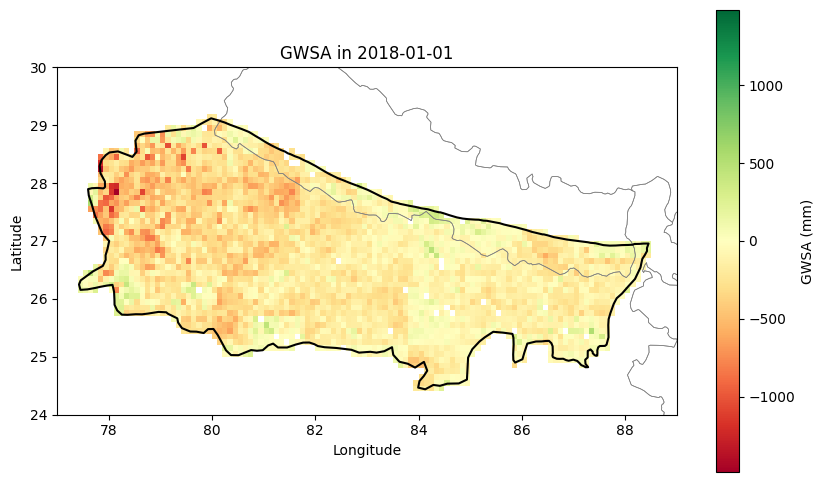

In [ ]:
# Assuming GR_DS_RE and nepal_shp are already loaded and processed
# Assuming corrected and nepal_shp are already loaded and processed
corrected = corrected.rio.write_crs('epsg:4326')
corrected = corrected.rio.clip(nepal_shp.geometry, all_touched=True)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 180
time_stamp = corrected.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the corrected gwsaitation data for the selected time
correctedTR = corrected.GWS_CR.isel(time=t).transpose('y', 'x')
correctedTR.plot(ax=ax, cmap='RdYlGn', add_colorbar=True, cbar_kwargs={'label': 'GWSA (mm)'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'GWSA in {time_str}')

plt.show()

<ipython-input-35-547873740>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df1 = df1.resample("M").mean()
<ipython-input-35-547873740>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = df2.resample("M").mean()


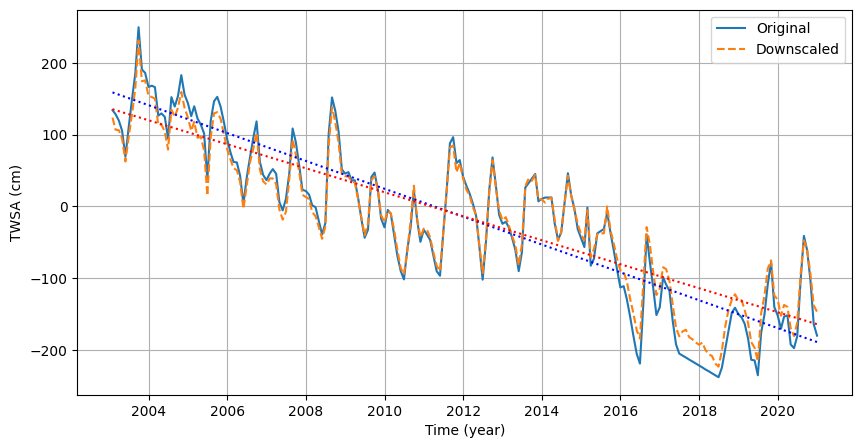

In [ ]:
# Compute the spatial mean (basin average)
basin_avg1 = GR["GWS"].mean(dim=["x", "y"])
basin_avg2 = corrected["GWS_CR"].mean(dim=["x", "y"])

# Convert to Pandas DataFrame
df1 = basin_avg1.to_dataframe().dropna()
df2 = basin_avg2.to_dataframe().dropna()

# Resample to monthly means
df1 = df1.resample("M").mean()
df2 = df2.resample("M").mean()

# Merge datasets on time index
df = df1.join(df2, how="inner")
start_date = '2003-01-01'
end_date = '2020-12-31'
df = df[(df.index >= start_date) & (df.index <= end_date)]

# Extract time as numerical values for trend analysis
time_numeric = (df.index - df.index[0]).days  # Convert to days since start

# Compute Sen’s slope for each dataset
slope1, intercept1, _, _ = theilslopes(df["GWS"].dropna(), time_numeric[df["GWS"].notna()])
slope2, intercept2, _, _ = theilslopes(df["GWS_CR"].dropna(), time_numeric[df["GWS_CR"].notna()])

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["GWS"], label="Original")
plt.plot(df.index, df["GWS_CR"], label="Downscaled", linestyle="--")

# Add Sen's slope trend lines
plt.plot(df.index, slope1 * time_numeric + intercept1, color="blue", linestyle="dotted")#, label="Sen's Slope GR")
plt.plot(df.index, slope2 * time_numeric + intercept2, color="red", linestyle="dotted")#, label="Sen's Slope GR_DS")

plt.xlabel("Time (year)")
plt.ylabel("TWSA (cm)")
#plt.title("Comparison of Basin Average LWE Thickness with Sen's Slope")
plt.legend()
plt.grid()
#plt.savefig('/content/drive/MyDrive/Thesis/RESULTS/GRACE/after_residual.png', dpi=300, bbox_inches='tight')
plt.show()